<h1 style="color: #8A2BE2;"><center>Keras Timeseries Anomaly Detection using an Autoencoder</center></h1>

This Project is an adaptation of the following documentation: https://keras.io/examples/timeseries/timeseries_anomaly_detection/

<h2 style="color: #8A2BE2;">Introduction</h2>

![alternatvie text](https://editor.analyticsvidhya.com/uploads/38009intro_anomaly_detection_plot.png)

<h3>What is Anomaly Detection?</h3>
Firstly an anomaly is an outcome we get that deviates from what we expected.[2] In the context of dealing with a data set, anomaly detection is a process where we can create algorithms to identify and show anomalies in the data.[3]
<h4 style="color: #00008B;">Real-World Example</h4>
The image above contains a timeseries graph, lets say for example it shows your monthly online shopping costs. It plots your spending for the month of september during which your laptop got hacked. Someone purchased expensive items using your saved credit card details. At the beginning of the month we can see an unexpected spike in your spending which increases past your average spending for the rest of the month. This spike is an anomaly which is marked in the image by a red circle. 

<h3>Why is Anomaly Detection important ?</h3>
Anomaly detection is used heavily in nearly every case involving data in today's world. One of the main areas is cybersecurity to identify data breaches or catch hackers. For the example I described above companies can use anomaly detection to notice a sudden increase in spending by a user and stop the purchase going through.[4]


<h3>Keras</h3>
Keras is a simple classifier model which is used along with tensorflow to created machine learning models in python. It helps define neural newtworks in an understandable way.[5]

***

<h2 style="color: #8A2BE2;">Creating The Model</h2>

Before we begin the following packages need to be imported and installed if not already done:

In [1]:
#install and import necessary packages needed to create the model

#Numerical arrays
import numpy as np

#Spreadsheet-like Data Frames 
import pandas as pd

#Neural Networks
import tensorflow.keras as keras

#Plotting
import matplotlib.pyplot as plt

<h2 style="color: #8A2BE2;">The Data</h2>
The dataset we are using is called Numenta Anomaly Benchmark(NAB) and contains 50 labeled real-world timeseries data on streaming applications that was retrieved from the real world (e.g Twitter, Google) and also data that was generated artificially[6][7][8]. The dataset along with its documentation can be found on:<br>

Kaggle: https://www.kaggle.com/datasets/boltzmannbrain/nab <br>
Github: https://github.com/numenta/NAB

First let's define all the URLs we need to use

In [2]:
# Root of URLs.
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

# Data file without anomaly.
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

# Data file with anomaly.
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

In [3]:
no_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv'

In [4]:
with_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv'

Next we can read in the datafile and create dataframes for small_noise and daily_jumpsup.

First Let's take a look at the small_noise dataframe which we will use as training set. This means we will train our model using this data. Our model will learn the patterns and properties of this data which contains no anomalies.

In [5]:
# dataframe small noise taken from no_anomaly_url and set the timestamp column as the index
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

In [6]:
# print out the first 5 lines of the dataframe
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


The dataset has 2 columns, a timestamp column and a value column.

In [7]:
# prints out some descriptive statistics of the dataset
df_small_noise.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


The information above gives us some insight into the small_noise dataset. There are 4032 rows and we can clearly see the mean, standard deviation(std), minimum and maximum value in the dataset(min,max) and the interquartile ranges (25%,50%,75%)[9].

In [8]:
# search for the data located in index 0 i.e the first row of data
df_small_noise.iloc[0]

value    18.324919
Name: 2014-04-01 00:00:00, dtype: float64

In [9]:
# search for the first row of data and return the column 'values'
df_small_noise.iloc[0]['value']

18.3249185392

In [10]:
# outputs a tuple describing the dimensions of the dataframe
df_small_noise.shape

(4032, 1)

Now let's take a look at the dataset when it is plotted

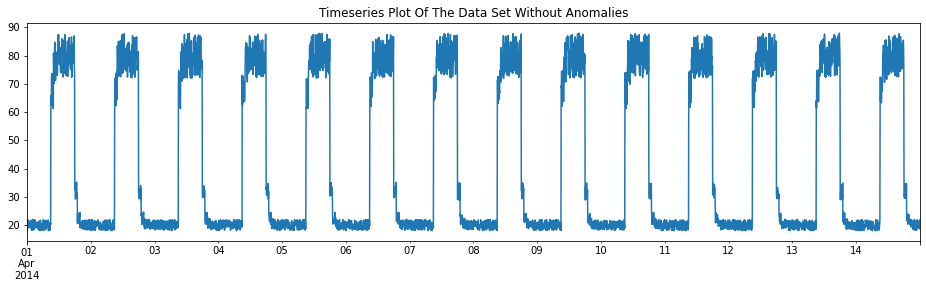

In [11]:
# Create a plot and set the size of the figure
fig, ax = plt.subplots(figsize=(16,4))

# Use pandas to plot small noise data frame and set legend to false
# ax=ax setting axes equal to the set of axes we created above using pyplot
#delete legend and x-axis label
# ";" gets rid of the return value of the function  
df_small_noise.plot(legend=False, ax=ax, title ='Timeseries Plot Of The Data Set Without Anomalies',xlabel="");

Next we will do the above analysis on the dataframe 'df_daily_jumpsup'. this dataset will be the test set. We will test our model on it after we train it. This dataset contains anomalies.

In [12]:
# dataframe daily_jumpsup taken from with_anomaly_url and set the timestamp column as the index
df_daily_jumpsup = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

In [13]:
# print out the first 5 lines of the dataframe
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


In [14]:
# prints out some descriptive statistics of the dataset
df_daily_jumpsup.describe()

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


In [15]:
# # search for the first row of data and return the column 'values'
df_daily_jumpsup.iloc[0]['value']

19.761251903

In [16]:
# outputs a tuple describing the dimensions of the dataframe
df_daily_jumpsup.shape

(4032, 1)

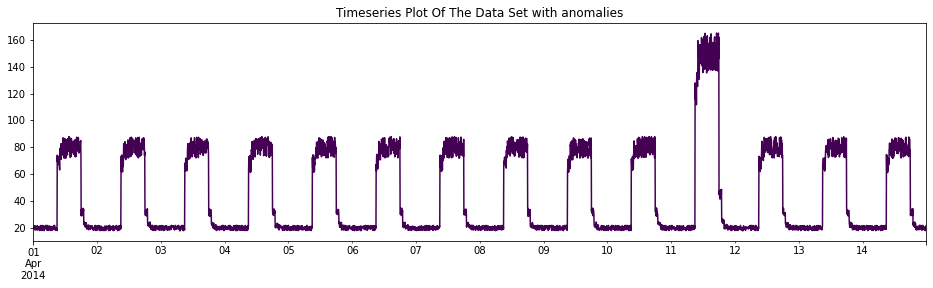

In [17]:
# Create a plot and set the size of the figure
fig, ax = plt.subplots(figsize=(16,4))

# Use pandas to plot small noise data frame and set legend to false
# ax=ax setting axes equal to the set of axes we created above using pyplot
#change color of plot [13]
# ";" gets rid of the return value of the function  
df_daily_jumpsup.plot(legend=False, ax=ax, title ='Timeseries Plot Of The Data Set with anomalies',xlabel="",colormap='viridis');

<h2 style="color: #8A2BE2;">Preprocessing The Data</h2>

Now we can prepare our training data.

<h3>Normalization</h3>
First we need to normalize the data. Currently our training set contains values between 18.001010 and 87.976128 so we want to convert these values and put them on a scale between 0 and 1. We can do this using normalization which will make our data scale smaller making it easier to work with the values. It also ensures that all data used in this model is placed on the same scale[10][11]. 

There are multiple methods for normalization. The method we will use is called standardization[12]. The formula is:
$$\frac {x-\mu}{\sigma}$$

In [18]:
# First get the mean
train_mean = df_small_noise.mean()

train_mean

value    42.438353
dtype: float64

In [19]:
# get the standard deviation
train_std = df_small_noise.std()

train_std

value    28.077122
dtype: float64

In [20]:
# Make a new dataset with normalized values
df_train_vals = (df_small_noise - train_mean) / train_std

Normalized training dataset:

In [21]:
# Print first 5 lines of dataset
df_train_vals.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


In [22]:
# show the steps of the calculation

#column showing each value after mean is subtracted
df_small_noise['less_mean'] = df_small_noise['value'] - df_small_noise['value'].mean()
#column showing each value after mean is subtracted and divided by standard deviation
df_small_noise['div_std'] = df_small_noise['less_mean'] / df_small_noise['value'].std()

Dataframe breaking down the normalizion calculation steps

In [23]:
#print dataframe
df_small_noise

,value,less_mean,div_std
timestamp,,,
2014-04-01 00:00:00,18.324919,-24.113435,-0.858829
2014-04-01 00:05:00,21.970327,-20.468026,-0.728993
2014-04-01 00:10:00,18.624806,-23.813547,-0.848148
2014-04-01 00:15:00,21.953684,-20.484669,-0.729586
2014-04-01 00:20:00,21.909120,-20.529234,-0.731173
...,...,...,...
2014-04-14 23:35:00,20.211195,-22.227159,-0.791647
2014-04-14 23:40:00,20.531041,-21.907313,-0.780255
2014-04-14 23:45:00,19.032127,-23.406226,-0.833640


In [24]:
#calculate the mean of all the columns in df showing normalizion calculation steps
df_small_noise['value'].mean(), df_small_noise['less_mean'].mean(), df_small_noise['div_std'].mean()

(42.438353335806646, -7.342627387941552e-14, -2.616541242931684e-15)

In [25]:
#calculate the standard deviation of all the columns in df showing normalizion calculation steps
df_small_noise['value'].std(), df_small_noise['less_mean'].std(), df_small_noise['div_std'].std()

(28.077122281262515, 28.077122281262508, 1.0000000000000018)

<h3>Plot Normalized Training Dataset</h3>

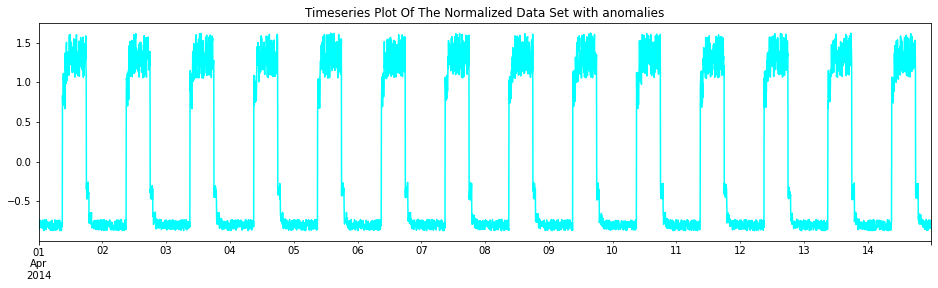

In [26]:
# Create a plot and set the size of the figure
fig, ax = plt.subplots(figsize=(16,4))

# Use pandas to plot small noise data frame and set legend to false
# ax=ax setting axes equal to the set of axes we created above using pyplot
#change color of plot [13]
# ";" gets rid of the return value of the function  
df_train_vals.plot(legend=False, ax=ax, title ='Timeseries Plot Of The Normalized Data Set with anomalies',xlabel="",colormap='cool');

The plot appears to be the same as before we normalized the dataset excpet the y-axis scale is now much smaller. This is what we want - the same pattern/trend in data just on a more manageable scale.

In [27]:
# check we still have 4032 rows
df_train_vals.shape

(4032, 1)

In [28]:
# split the data up into groups of 288 values 
window_size = 288

Window example:

[1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]<br>
window_size = 3 <br>
[1, 1, 2]<br>
[1, 2, 4]<br>
[2, 4, 5]<br>
[4, 5, 6]<br>
...


In [29]:
# Window list example.
L = [1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
# Example window size.
win_size = 3
# Length of L.
len(L)

12

In [30]:
# Number of windows from L.
len(L) - (win_size - 1)

10

In [31]:
# Remove brackets.
len(L) - win_size + 1

10

In [32]:
# Print the windows.
for i in range(len(L) - win_size + 1):
    print(L[i:i + win_size])

[1, 1, 2]
[1, 2, 4]
[2, 4, 5]
[4, 5, 6]
[5, 6, 7]
[6, 7, 1]
[7, 1, 2]
[1, 2, 3]
[2, 3, 4]
[3, 4, 5]


The above window example takes a list of numbers and splits it into lists with three elements. It does the by starting with index 0-2, then index 1-3 and so on (increasing the first and last index taken from by 1 each time).

Demonstrate the above example using a function to fill an empty list called wins

In [33]:
# For accumulating the windows.
wins = []

# Generate the windows
for i in range(len(L) - win_size + 1):
    wins.append(L[i:i + win_size])

wins

[[1, 1, 2],
 [1, 2, 4],
 [2, 4, 5],
 [4, 5, 6],
 [5, 6, 7],
 [6, 7, 1],
 [7, 1, 2],
 [1, 2, 3],
 [2, 3, 4],
 [3, 4, 5]]

In [34]:
# Create a 2D numpy array from wins.
np.stack(wins)

array([[1, 1, 2],
       [1, 2, 4],
       [2, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 1],
       [7, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]])

In [35]:
# function takes in a list of values and window size and splits the values into groups of size=window size 
# adds these new groups as separate lists to an empty array L
#returns L with its lists stacked 
def windows(vals, N=window_size):
  # start with an empty list
  L = []
  # loop through all the possible windows
  for i in range(len(vals) - N + 1):
    # append window to the list
    L.append(vals[i:i+N])
  # Stack them all
  return np.stack(L)

In [36]:
# pass the training values into the windows function
x_train = windows(df_train_vals)

In [37]:
# check the first value in first window and last value in last window
x_train[0][0], x_train[-1][-1]

(array([-0.85882857]), array([-0.8460886]))

In [38]:
# check first row of training set and last row of training set
df_train_vals.iloc[0], df_train_vals.iloc[-1]

(value   -0.858829
 Name: 2014-04-01 00:00:00, dtype: float64,
 value   -0.846089
 Name: 2014-04-14 23:55:00, dtype: float64)

In [39]:
# check the 3 dimensions of dataframe now
x_train.shape

(3745, 288, 1)

We have 3745 training examples/windows of size 288. We have less values than we have windows in the array because the 288th element of the window eventually gets to the end of the array and then we can't continue or we would have arrays with less than 288 values.

In [40]:
#print values in the values column
df_train_vals['value'].values

array([-0.85882857, -0.72899302, -0.84814772, ..., -0.83364049,
       -0.73510213, -0.8460886 ])

In [41]:
# flatten matrix of first column to one dimension
x_train[0].flatten()

array([-0.85882857, -0.72899302, -0.84814772, -0.72958579, -0.731173  ,
       -0.75730984, -0.77645641, -0.7880838 , -0.747012  , -0.829166  ,
       -0.80377285, -0.7821597 , -0.81182078, -0.80949918, -0.82334701,
       -0.79001779, -0.74922405, -0.84169024, -0.73727717, -0.77223023,
       -0.75311352, -0.79116337, -0.75934728, -0.86809294, -0.75381057,
       -0.86468256, -0.74361965, -0.72908121, -0.82850668, -0.84043795,
       -0.76136364, -0.8343536 , -0.74708881, -0.85574949, -0.85245676,
       -0.73090636, -0.77440264, -0.74974936, -0.82419543, -0.77402585,
       -0.78574242, -0.7844733 , -0.77316412, -0.78843253, -0.80927467,
       -0.83109167, -0.76090519, -0.83816509, -0.77176485, -0.83715923,
       -0.78131343, -0.76396862, -0.83924191, -0.86186112, -0.85174179,
       -0.78406773, -0.74938477, -0.86399047, -0.76581026, -0.82177506,
       -0.80222751, -0.73807119, -0.82310669, -0.80410682, -0.86845167,
       -0.85877599, -0.83356075, -0.86643297, -0.78045221, -0.80

<h3>Plot Training Dataset Showing One Of the Windows</h3>

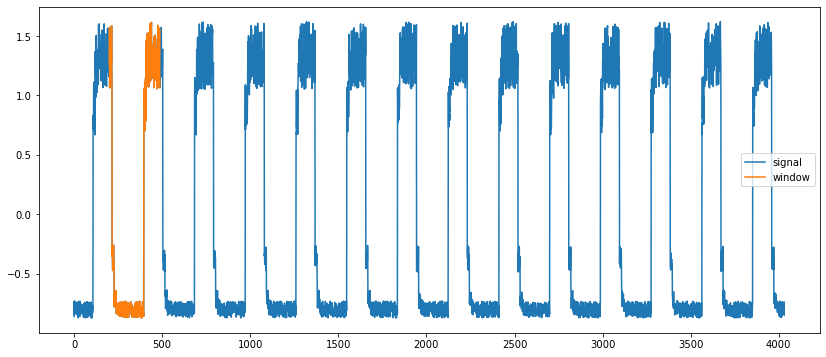

In [42]:
# The window we want to look at
window_no = 200

# Create a plot and set the size of the figure
fig, ax = plt.subplots(figsize=(14, 6))

# define y values as value column in training dataset
y = df_train_vals['value'].values

# plot the training values and label them as the signal
ax.plot(np.arange(y.shape[0]), y, label='signal')

# The 200th window.
w = x_train[window_no].flatten()

# plot the window in orange
ax.plot(np.arange(w.shape[0]) + window_no, w, label='window')
#add a legend
ax.legend();

***

<h2 style="color: #8A2BE2;">Neural Networks</h2>

![alternatvie text](https://b2633864.smushcdn.com/2633864/wp-content/uploads/2016/08/simple_neural_network_header-768x377.jpg?lossy=1&strip=1&webp=1)


A neural network is made up of interlinked layers that look like the image above. Input data flows into the input layer and is then processed by hidden layer 1 then hidden layer 2 and so on until it reaches the output layer. The data starts by flowing through the network from left to right and then goes backwards after it reaches the output layer and then forwards back to the output layer as it learns the properties/pattern of the data.[15][16]

<h4>Keras Sequential Model</h4>
This model is essentially a stack of layers and is a convolutional neural networks. The Conv1D is a 1 dimensional convolutional layer. A convolutional neural network has hidden layers that perform mathematical functions on the data called convolutions. The activation function in the model decides if a data point is relevant or not in predicting the output set of the neural network. In this model we use the ReLU function (rectified linear unit) as the activation function. [16][17][18]

In [43]:
x_train.shape[2]

1

In [44]:
#create an array of the layers we want to use in our model
layers = [
  #define the input layer which takes in the dimension of the the windows
  keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
  #creates convolutional kernel that takes in filters=32 means 32 output convolutions,padding=same means keep the padding same
  #kernel_size is size of convolutions, strides specifies the stride length of the convolution, 
  #activation specifies the activation function [19]
  keras.layers.Conv1D(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  #prevents overfitting
  #sets a rate at which random data points are dropped out of the test[20]  
  keras.layers.Dropout(rate=0.2),
  #does the same as above with different filter
  keras.layers.Conv1D(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  #transposes the convolutional layer[21]
  keras.layers.Conv1DTranspose(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  #applies dropout again
  keras.layers.Dropout(rate=0.2),
  #another transpose the convolution layer with diff filter
  keras.layers.Conv1DTranspose(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  #another transpose the convolution layer with diff filter
  keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]

In [45]:
# Creates a deep learning model and passes the layers through it 
model = keras.Sequential(layers)

<h4>Gradient Descent</h4>
Gradient descent is a method that calculates the error between the predicted output and the actual about and it continue to calculate step by step through the data until a minimum error is achieved. The learning rate specifies the size of the steps taken. A large learning rate can cause under fitting and a small learning rate can cause over fitting.[23][24][25]

In [46]:
# gradient descent method that takes in a learning rate[22]
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [47]:
# use mean squared error to calculate the difference between predicted and actual
model.compile(optimizer=optimizer, loss="mse")

In [48]:
#summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

In [49]:
#start training the model using training set, set 128 as batch size(no. of data entries to pass through model in one iteration)
#and 50 as epochs (amount of times whole dataset gets passed through the model) 
#validation split specifies how much of the data will be set aside to test
#callbacks stops it printing a long output
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 5s 107ms/step - loss: 0.6514 - val_loss: 0.4075
Epoch 2/50
27/27 [==============================] - 2s 73ms/step - loss: 0.1440 - val_loss: 0.0603
Epoch 3/50
27/27 [==============================] - 2s 79ms/step - loss: 0.0589 - val_loss: 0.0366
Epoch 4/50
27/27 [==============================] - 2s 74ms/step - loss: 0.0488 - val_loss: 0.0315
Epoch 5/50
27/27 [==============================] - 2s 78ms/step - loss: 0.0428 - val_loss: 0.0289
Epoch 6/50
27/27 [==============================] - 3s 96ms/step - loss: 0.0385 - val_loss: 0.0265
Epoch 7/50
27/27 [==============================] - 3s 96ms/step - loss: 0.0349 - val_loss: 0.0252
Epoch 8/50
27/27 [==============================] - 2s 74ms/step - loss: 0.0320 - val_loss: 0.0247
Epoch 9/50
27/27 [==============================] - 2s 81ms/step - loss: 0.0292 - val_loss: 0.0248
Epoch 10/50
27/27 [==============================] - 2s 74ms/step - loss: 0.0269 - val_loss: 0.0224
Epoch 11

In [50]:
#show loss column
history.history["loss"]

[0.6514021754264832,
 0.14396366477012634,
 0.05885094776749611,
 0.04883912578225136,
 0.04277637228369713,
 0.03848975524306297,
 0.034920815378427505,
 0.031983133405447006,
 0.029209282249212265,
 0.02694098837673664,
 0.025095924735069275,
 0.023405462503433228,
 0.02206462249159813,
 0.020909352228045464,
 0.01984509266912937,
 0.018921343609690666,
 0.01806289330124855,
 0.017297517508268356,
 0.016653135418891907,
 0.016031067818403244,
 0.015527677722275257,
 0.014986175112426281,
 0.01441378053277731,
 0.013907241635024548,
 0.013262394815683365,
 0.012742453254759312,
 0.012170854955911636,
 0.011736897751688957,
 0.011293825693428516,
 0.010958940722048283,
 0.010634983889758587,
 0.010351541452109814,
 0.010116606950759888,
 0.009778942912817001,
 0.009572821669280529,
 0.009374403394758701,
 0.00910656712949276,
 0.008918749168515205,
 0.008683699183166027,
 0.008419563062489033,
 0.008146056905388832,
 0.007842881605029106,
 0.007599815726280212,
 0.007423243019729853,
 

In [51]:
#show val_loss column
history.history["val_loss"]

[0.40750959515571594,
 0.06025107204914093,
 0.036603894084692,
 0.031451527029275894,
 0.02890068106353283,
 0.026450684294104576,
 0.025172490626573563,
 0.024676010012626648,
 0.024763843044638634,
 0.0223934855312109,
 0.021052997559309006,
 0.019102338701486588,
 0.018840106204152107,
 0.01767825148999691,
 0.016303854063153267,
 0.015392255038022995,
 0.015256417915225029,
 0.014479044824838638,
 0.013874105177819729,
 0.012697344645857811,
 0.012596224434673786,
 0.012190597131848335,
 0.011688229627907276,
 0.011127928271889687,
 0.010360993444919586,
 0.00931643508374691,
 0.008897746913135052,
 0.008459015749394894,
 0.008548939600586891,
 0.008442130871117115,
 0.007872916758060455,
 0.007909904234111309,
 0.007354157976806164,
 0.007689004763960838,
 0.007386067882180214,
 0.007316687144339085,
 0.0070221805945038795,
 0.006983924191445112,
 0.0066529870964586735,
 0.006366604007780552,
 0.005961019080132246,
 0.005711155477911234,
 0.005380486603826284,
 0.0051708049140870

<h2 style="color: #8A2BE2;">How well did the model do ?</h2>

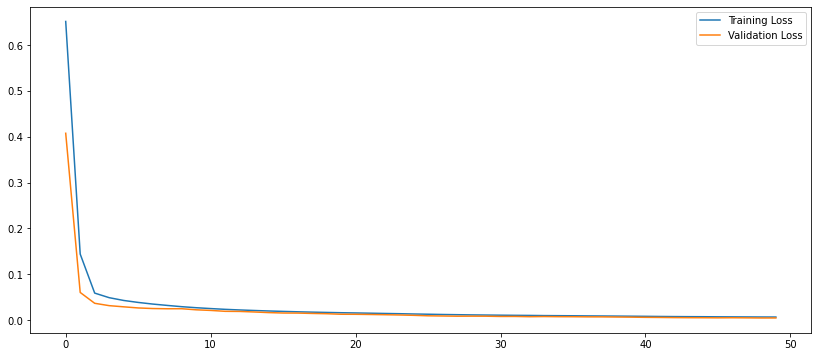

In [52]:
# create a plot and set figure size
fig, ax = plt.subplots(figsize=(14, 6))
# plot training loss in blue
ax.plot(history.history["loss"], label="Training Loss")
# plot validation loss in orange
ax.plot(history.history["val_loss"], label="Validation Loss")
# add legend
ax.legend();

The above plot shows how well the model fit the training set vs the validation set as it progresses through the epochs. The validation data is the data that was kept aside and model was tested with it as new data after fitting the training data. As you can see the model progressively improves as the loss decreases as it moves towards 50 epochs.

In [53]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)

118/118 [==============================] - 1s 7ms/step


In [54]:
# Calculate loss...
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

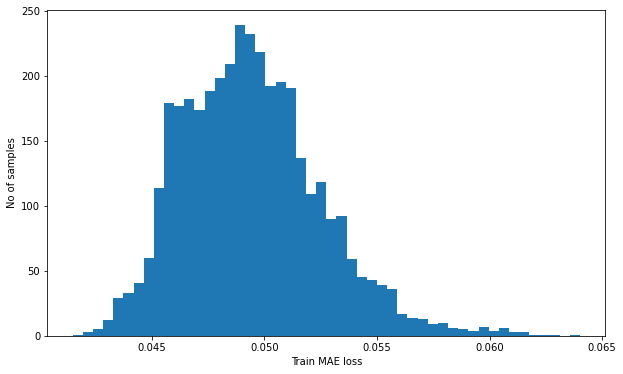

In [55]:
# create a plot and set figsize
fig, ax = plt.subplots(figsize=(10, 6))
# create a histogram
ax.hist(train_mae_loss, bins=50)
# set x axis label
ax.set_xlabel("Train MAE loss")
# set y axis label
ax.set_ylabel("No of samples");

In [56]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)

# 
threshold

0.06401665118236106

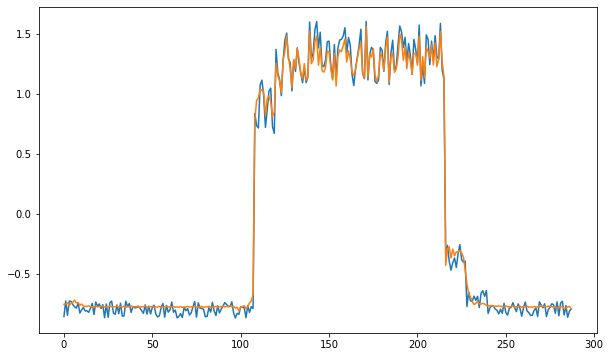

In [57]:
# create a plot
fig, ax = plt.subplots(figsize=(10, 6))

# plot training set
ax.plot(x_train[0])

# plot predictions
ax.plot(x_train_pred[0]);

<h4>Analysis</h4>
The plot shows the training set values vs the predicted values of the training set. It is clear the model did a good job at predicting the values as both trends seem to overlap quite alot.[26][27]

<h4>Create a test dataset</h4>

In [58]:
# normalise test values
df_test_value = (df_daily_jumpsup - train_mean) / train_std

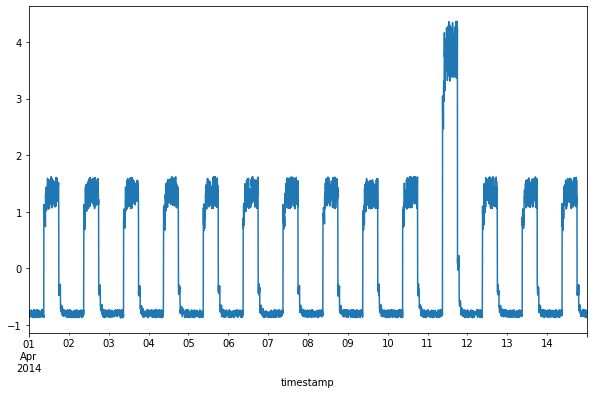

In [59]:
# create plot
fig, ax = plt.subplots(figsize=(10, 6))

# plot test values
df_test_value.plot(legend=False, ax=ax);

In [60]:
# Create sequences from test values.
x_test = windows(df_test_value.values)

x_test.shape

(3745, 288, 1)

In [61]:
# use the model to predict values of the test set
x_test_pred = model.predict(x_test)

118/118 [==============================] - 1s 6ms/step


In [62]:
# get the mean squared error
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

test_mae_loss

array([[0.04523225],
       [0.04934918],
       [0.04774573],
       ...,
       [0.05242613],
       [0.0523433 ],
       [0.05302869]])

In [63]:
# put the mean absolute error values in one array
test_mae_loss = test_mae_loss.reshape((-1))

test_mae_loss

array([0.04523225, 0.04934918, 0.04774573, ..., 0.05242613, 0.0523433 ,
       0.05302869])

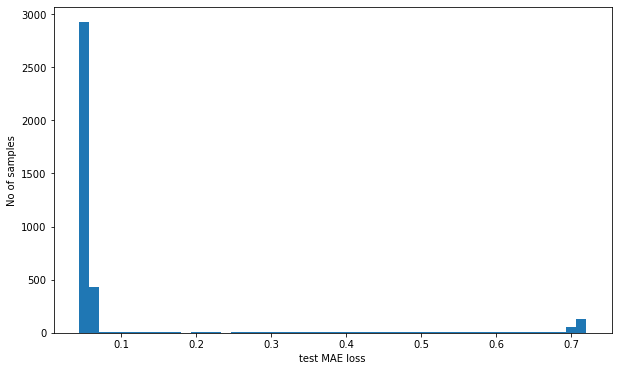

In [64]:
# create a plot
fig, ax = plt.subplots(figsize=(10, 6))

#create a hisogram showing the errors recieved when predicting the test set 
ax.hist(test_mae_loss, bins=50)

# set x axis labels
ax.set_xlabel("test MAE loss")

# set y axis labels
ax.set_ylabel("No of samples");

Analysis: The mean absolute error seems to be low for most of the values except a couple of hundred that got a higher error

In [65]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold

# NUmber of anomalies.
np.sum(anomalies)

414

In [66]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
inds = []

for i in range(window_size - 1, len(df_test_value) - window_size + 1):
    if np.all(anomalies[i - window_size + 1 : i]):
        inds.append(i)

In [67]:
# anomalies in dataset
df_subset = df_daily_jumpsup.iloc[inds]

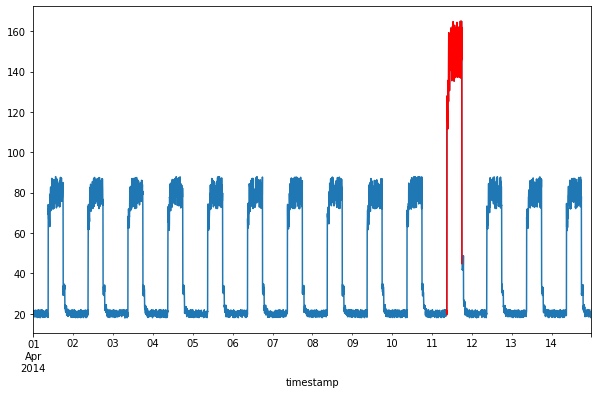

In [68]:
#create a plot 
fig, ax = plt.subplots(figsize=(10, 6))

# plot the dataset with anomalies
df_daily_jumpsup.plot(legend=False, ax=ax)

# plot the subset of anomalies in a red colour
df_subset.plot(legend=False, ax=ax, color="r");

<h2 style="color: #8A2BE2;">Conclusion</h2>

The keras classifier model is a good model to use for detecting anomalies in a dataset. The model predicted the test dataset very well in comparison to the training dataset. It also had a low mean absolute errors which means there was little difference between the actual data and the predicted data. When the model was given anomalies it handled them well and didn't ignore them so they show up in the output data, this is good as we can detect them.

Possible improvements that could be made in my documentation would be to try out more examples and use a wider variety of graphs to plot the concepts. A deeper analysis could be made on all the machine learning processes that were carried out as there is an endless number of resources to gain a proper understanding of whats happening in the background.

<h2 style="color: #8A2BE2;">Reference:</h2>

[1] https://keras.io/examples/timeseries/timeseries_anomaly_detection/ <br>
[2] https://www.google.com/search?q=anomaly+meaning&rlz=1C1CHBF_enIE846IE846&oq=anomaly&aqs=chrome.1.69i57j0i131i433i512j0i512j0i131i433i512j0i512j69i60j69i61l2.4659j0j7&sourceid=chrome&ie=UTF-8 <br>
[3] https://www.analyticsvidhya.com/blog/2021/08/univariate-time-series-anomaly-detection-using-arima-model/#h2_1 <br>
[4] https://www.mindbridge.ai/blog/what-is-anomaly-detection-and-why-is-it-important/#:~:text=Anomaly%20detection%20is%20the%20ability,control%20failures%2C%20or%20business%20opportunities. <br>
[5] https://www.activestate.com/resources/quick-reads/what-is-a-keras-model/ <br>
[6] https://www.kaggle.com/datasets/boltzmannbrain/nab <br>
[7] https://github.com/numenta/NAB <br>
[8] https://www.sciencedirect.com/science/article/pii/S0925231217309864 <br>
[9] https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html <br>
[10] https://developers.google.com/machine-learning/data-prep/transform/normalization <br>
[11] https://learn.microsoft.com/en-us/azure/machine-learning/component-reference/normalize-data <br>
[12] https://medium.com/@mkc940/different-normalization-methods-a1be71fe9f1 <br>
[13] https://matplotlib.org/stable/tutorials/colors/colormaps.html
[14] https://www.geeksforgeeks.org/flatten-a-matrix-in-python-using-numpy/ <br>
[15] https://aws.amazon.com/what-is/neural-network/#:~:text=A%20neural%20network%20is%20a,that%20resembles%20the%20human%20brain.<br>
[16] https://www.ibm.com/topics/neural-networks <br>
[17] https://www.v7labs.com/blog/neural-networks-activation-functions#:~:text=drive%20V7's%20tools.-,What%20is%20a%20Neural%20Network%20Activation%20Function%3F,prediction%20using%20simpler%20mathematical%20operations.
[18] https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/
[19] https://keras.io/api/layers/convolution_layers/convolution1d/
[20] https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
[21] https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1DTranspose
[22] https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
[23] https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21
[24] https://www.ibm.com/topics/gradient-descent#:~:text=Gradient%20descent%20is%20an%20optimization,each%20iteration%20of%20parameter%20updates.
[25] https://en.wikipedia.org/wiki/Overfitting
[26] https://www.baeldung.com/cs/learning-curve-ml#:~:text=The%20training%20loss%20indicates%20how,the%20model%20fits%20new%20data.&text=Another%20common%20practice%20is%20to,those%20metrics%20for%20different%20models.
[27] https://towardsdatascience.com/understanding-the-3-most-common-loss-functions-for-machine-learning-regression-23e0ef3e14d3